In [3]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.2 MB 1.8 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=126817d78bed058b2e9d40bdc9f862a56b372110de313c9e97b849ffc39ba4e8
  Stored in directory: /Users/Ouser/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
You should consider upgrading via the '/Users/Ouser/.pyenv/versions/3.7.9/bin/python -m pip install --upgrade pip' command.


In [4]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [5]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv             11_groups.csv             product_groups.csv
10_groups.csv             bad_ids - bad_ids.csv.csv


In [6]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [35]:
g_10 = pd.read_csv('./data/10_groups.csv')
g_10.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-10-01 20:22:55,2035558,0.0,1636749,52,339,1.0,107.90,0,10004
1,2020-10-01 20:54:12,13037327,0.0,267261,52,339,1.0,80.04,0,10004
2,2020-10-01 21:25:59,1430590,0.0,1331395,61,379,1.0,31.92,1,10091
3,2020-10-01 13:31:01,3504660,0.0,641525,61,97,1.0,55.98,0,10091
4,2020-10-01 16:32:06,11024438,0.0,1325852,61,97,4.0,176.00,0,10091


In [36]:
g_11 = pd.read_csv('./data/11_groups.csv')
g_11.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-11-01 15:29:01,3121751,0.0,332351,52,271,1.0,107.98,0,10004
1,2020-11-01 12:41:10,22047017,8293317.0,1875438,52,-9999,1.0,108.00,0,10004
2,2020-11-01 13:17:09,6419825,0.0,563112,61,379,2.0,112.00,0,10091
3,2020-11-01 12:31:31,10284541,0.0,1841710,61,379,1.0,55.91,0,10091
4,2020-11-01 13:06:15,10424967,0.0,1304277,61,271,2.0,87.80,0,10091


In [37]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


## Preprocessing

In [9]:
df = g_9
bad_ids = pd.read_csv('./data/bad_ids.csv')
df = df[~df['id_card'].isin(set(bad_ids['id_card']))]

In [15]:
g_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100858 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.1+ GB


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38466003 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ GB


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

In [26]:
grouped = df.groupby(by=['id_doc'])[['sum', 'is_green']]
discounted = grouped.sum()
discounted = discounted[discounted['is_green'] > 0]
discounted.describe()

,sum,is_green
count,1.064042e+06,1.064042e+06
mean,6.036525e+02,2.454380e+00
std,5.999258e+02,2.361772e+00
min,0.000000e+00,1.000000e+00
25%,2.231000e+02,1.000000e+00
50%,4.259800e+02,2.000000e+00
75%,7.750000e+02,3.000000e+00
max,1.476323e+04,7.200000e+01


In [27]:
not_discounted = grouped.sum()
not_discounted = not_discounted[not_discounted['is_green'] == 0]
not_discounted.describe()

,sum,is_green
count,5.840783e+06,5840783.0
mean,6.532083e+02,0.0
std,6.931715e+02,0.0
min,0.000000e+00,0.0
25%,2.200000e+02,0.0
50%,4.330000e+02,0.0
75%,8.310000e+02,0.0
max,4.800500e+04,0.0


In [28]:
from scipy.stats import ttest_ind

ttest_ind(discounted, not_discounted, equal_var = False)

Ttest_indResult(statistic=array([ -76.41968792, 1071.97124608]), pvalue=array([0., 0.]))

In [30]:
from scipy.stats import pearsonr

sums = grouped.sum()['sum']
greens = grouped.mean()['is_green']

pearsonr(sums, greens)

(-0.11211405758849058, 0.0)

As you can see, the distributions are different, and there is negative correlation. So, if the sum of check is bigger, it is less likely to have discounted products in the check.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [106]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df['datetime'] = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df['day'] = df.index.day
# df['day_of_week'] = df.index.dayofweek
# checks = df.groupby(by=['id_doc']).first()
# checks.index = pd.to_datetime(checks['date'],format='%Y-%m-%d %H:%M:%S')
# sum_of_spendings_per_month = checks.groupby(by=[checks.index.day])['id_doc'].count()
sum_of_spendings_per_month = df.groupby(by=[df.index.day])[['id_doc', 'day_of_week']] \
                            .agg({"id_doc": "nunique", "day_of_week": "first"})
sum_of_spendings_per_week = df.groupby(by=[df.index.dayofweek])[['id_doc']].nunique()
# agg({"C": np.sum, "D": lambda x: np.std(x, ddof=1)})

/Users/Ouser/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Ouser/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


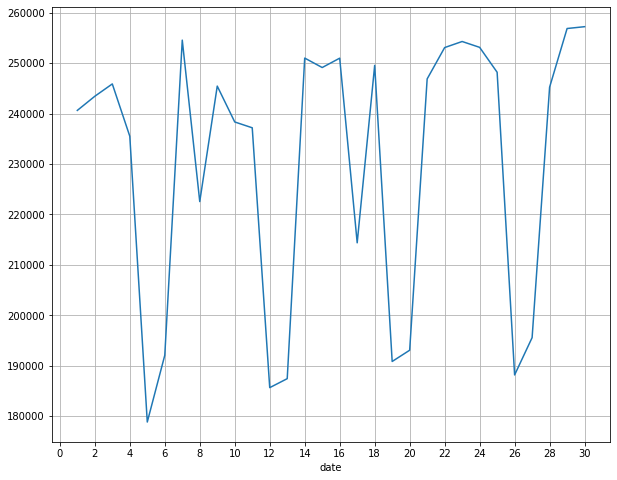

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.locator_params(axis="x", nbins=30)
sum_of_spendings_per_month['id_doc'].plot()
plt.grid()

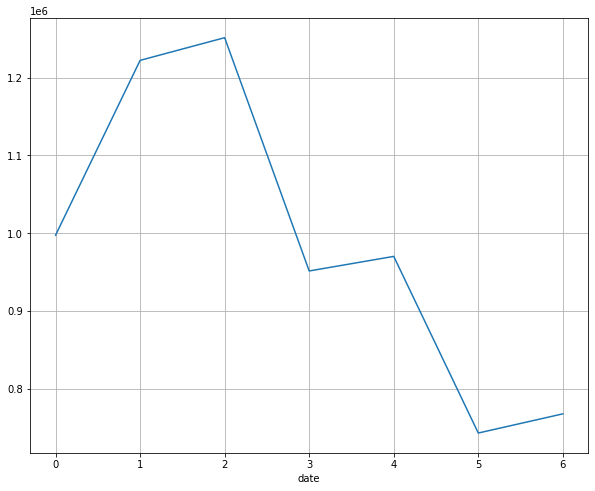

In [76]:
plt.figure(figsize=(10,8))
plt.locator_params(axis="x", nbins=7)
sum_of_spendings_per_week['id_doc'].plot()
plt.grid()

As you can see, weekly seasonality is much stronger than seasonality of wage days.

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Frequent buyers

In [117]:
users = df.groupby(by=['id_card'], as_index=False)
amount_of_orders = users.agg({"id_doc": "nunique"}).sort_values(by=['id_doc'], ascending=False)
amount_of_orders.head(10)

,id_card,id_doc
454093,620767,161
1086278,1523082,119
682074,943480,109
1115966,1567258,104
822920,1144271,103
1270981,1808366,103
920587,1284105,102
221729,297039,101
655058,904949,98
1258811,1789392,98


### Cohorts by number of orders

In [118]:
amount_of_orders['id_card'] = amount_of_orders.index
cohorts_by_num_of_orders = amount_of_orders.groupby(by=['id_doc'], as_index=False)['id_card'].count()
cohorts_by_num_of_orders                                      

,id_doc,id_card
0,1,406287
1,2,205028
2,3,135162
3,4,99732
4,5,77610
...,...,...
84,103,2
85,104,1
86,109,1
87,119,1


### Customers who orders every day

In [ ]:
everyday_bro = users['day'].nunique()
everyday_bro.reset_index()
everyday_bro = everyday_bro[everyday_bro['day'] >= 30]
everyday_bro.head()